# Test imputation on untyped SNPs chrom 20 

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


In [7]:
# 8 threads, d = 1000
Random.seed!(2020)
tgtfile = "target.chr20.typedOnly.masked.vcf.gz"
reffile = "ref.chr20.excludeTarget.jlso"
outfile = "mendel.imputed.chr20.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile);

X_complete = convert_gt(UInt8, "target.chr20.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 546, averaging ~ 449 unique haplotypes per window.

Timings: 
    Data import                     = 9.4186 seconds
        import target data             = 0.571877 seconds
        import compressed haplotypes   = 8.84672 seconds
    Computing haplotype pair        = 0.715624 seconds
        BLAS3 mul! to get M and N      = 0.0353204 seconds per thread
        haplopair search               = 0.610168 seconds per thread
        initializing missing           = 0.00167775 seconds per thread
        allocating and viewing         = 0.00520958 seconds per thread
        index conversion               = 0.000273516 seconds per thread
    Phasing by win-win intersection = 0.0751581 seconds
        Window-by-window intersection  = 0.0187382 seconds per thread
        Breakpoint search              = 0.0387753 seconds per thread
        Recording result               = 0.00947009 seconds per thread
    Imputation     

In [12]:
using GeneticVariation, Plots
reader = VCF.Reader(openvcf(outfile, "r"))
snpscores = Vector{Float64}(undef, nrecords(outfile))

# loop over SNPs
for (i, record) in enumerate(reader)
    snpscores[i] = parse(Float64, VCF.info(record)[1].second)
end
close(reader)

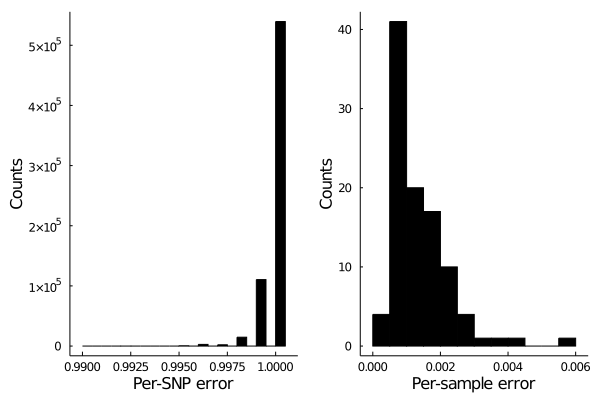

In [13]:
# plot histogram of SNP scores
snperr = histogram(snpscores, label=:none, xlabel="Per-SNP error", grid=false, 
    color=:black, ylabel="Counts", bins=20)

using CSV
quality = CSV.read("mendel.chr20.imputed.sample.error") # import quality score 

# visualize error distribution
sampleerr = histogram(quality[:error], label=:none, xlabel="Per-sample error", color=:black,
    grid=false, ylabel="Counts", xticks = 0:0.002:0.006) 

err_plot = plot(snperr, sampleerr, grid=(2, 1))

In [26]:
savefig(err_plot, "error.png") # remember to set dpi=300

## Generate subset of markers for prephasing

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function filter_and_mask()
    for chr in [20]
        # filter chromosome data for unique snps
        data = "../beagle_raw/chr$chr.1kg.phase3.v5a.vcf.gz"
        full_record_index = .!find_duplicate_marker(data)
        @time VCFTools.filter(data, full_record_index, 1:nsamples(data), 
            des = "chr$chr.uniqueSNPs.vcf.gz")

        # summarize data
        total_snps, samples, _, _, _, maf_by_record, _ = gtstats("chr$chr.uniqueSNPs.vcf.gz")
        large_maf = findall(x -> x > 0.005, maf_by_record)  

        # generate target file with 100 samples and keep snps with maf>0.005 as typed SNPs
        n = 100
        p = length(large_maf)
        record_idx = falses(total_snps)
        record_idx[large_maf] .= true
        sample_idx = falses(samples)
        sample_idx[1:n] .= true
        shuffle!(sample_idx)
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
            des = "target.chr$chr.typedOnly.vcf.gz")

        # generate target panel with all snps
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 
            1:total_snps, sample_idx, des = "target.chr$chr.full.vcf.gz")

        # also generate reference panel without target samples
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 
            1:total_snps, .!sample_idx, des = "ref.chr$chr.excludeTarget.vcf.gz")

        # unphase and mask 1% entries in target file
        masks = falses(p, n)
        missingprop = 0.001
        for j in 1:n, i in 1:p
            rand() < missingprop && (masks[i, j] = true)
        end
        @time mask_gt("target.chr$chr.typedOnly.vcf.gz", masks, 
            des="target.chr$chr.typedOnly.masked.vcf.gz", unphase=true)

        # generate subset of reference file that matches target file
        @time conformgt_by_pos("ref.chr$chr.excludeTarget.vcf.gz", 
            "target.chr$chr.typedOnly.masked.vcf.gz", 
            "chr$chr.aligned", "$chr", 1:typemax(Int))
        if nrecords("chr$chr.aligned.tgt.vcf.gz") == p
            rm("chr$chr.aligned.tgt.vcf.gz", force=true) # perfect match
        else
            error("target file has SNPs not matching in reference file! Shouldn't happen!")
        end
        mv("chr$chr.aligned.ref.vcf.gz", "ref.chr$chr.aligned.vcf.gz", force=true)
    end 
end
Random.seed!(2020)
@time filter_and_mask()

634.791378 seconds (5.12 G allocations: 482.584 GiB, 6.73% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:09:39


458.821619 seconds (5.30 G allocations: 502.982 GiB, 10.16% gc time)
462.232565 seconds (5.45 G allocations: 517.732 GiB, 10.34% gc time)
1071.281820 seconds (13.27 G allocations: 1016.904 GiB, 11.08% gc time)
 19.325729 seconds (119.00 M allocations: 12.223 GiB, 5.94% gc time)


┌ Info: Match target POS to reference POS
└ @ VCFTools /Users/biona001/.julia/dev/VCFTools/src/conformgt.jl:172
Progress: 100%|█████████████████████████████████████████| Time: 0:19:40


1207.640069 seconds (15.55 G allocations: 1.374 TiB, 14.84% gc time)


┌ Info: 379432 records are matched
└ @ VCFTools /Users/biona001/.julia/dev/VCFTools/src/conformgt.jl:239


4887.106827 seconds (58.46 G allocations: 5.088 TiB, 11.21% gc time)


### Missing rate

In typed markers, 0.1% of data is missing at random. In addition, 56% of all markers are not typed (i.e. systematically missing). 

In [5]:
tgtfile = "target.chr20.typedOnly.masked.vcf.gz"
reffile = "ref.chr20.excludeTarget.vcf.gz"
missing_rate = 1 - nrecords(tgtfile) / nrecords(reffile)

0.44082516280872497

In [ ]:
Threads.nthreads()

In [7]:
tgtfile = "target.chr20.typedOnly.masked.vcf.gz"
reffile = "ref.chr20.excludeTarget.vcf.gz"
reffile_aligned = "ref.chr20.aligned.vcf.gz"
X_typedOnly_complete = "target.chr20.typedOnly.vcf.gz"
X_full_complete = "target.chr20.full.vcf.gz"
@show nrecords(tgtfile), nsamples(tgtfile)
@show nrecords(reffile), nsamples(reffile)
@show nrecords(reffile_aligned), nsamples(reffile_aligned)
@show nrecords(X_typedOnly_complete), nsamples(X_typedOnly_complete)
@show nrecords(X_full_complete), nsamples(X_full_complete)

(nrecords(tgtfile), nsamples(tgtfile)) = (379432, 100)
(nrecords(reffile), nsamples(reffile)) = (678557, 2404)
(nrecords(reffile_aligned), nsamples(reffile_aligned)) = (379432, 2404)
(nrecords(X_typedOnly_complete), nsamples(X_typedOnly_complete)) = (379432, 100)
(nrecords(X_full_complete), nsamples(X_full_complete)) = (678557, 100)


(678557, 100)

# MendelImpute on untyped markers with dp

Due to memory constraints, only first run is fast

In [3]:
# ad-hoc dp method, keep pairs within 3 of best pair, keep all pairs minimizing diff w/ observed error
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
function run()
#     X_complete = convert_gt(Float32, "target.chr20.typedOnly.vcf.gz")
    X_complete = convert_gt(Float32, "target.chr20.full.vcf.gz")
    n, p = size(X_complete)
    chr = 20
    for width in [250, 500, 1000]
        println("Imputing typed + untyped SNPs with dynamic programming, width = $width")
        tgtfile = "target.chr$chr.typedOnly.masked.vcf.gz"
        reffile = "ref.chr$chr.excludeTarget.vcf.gz"
        outfile = "mendel.imputed.dp$width.vcf.gz"
        @time phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
            fast_method=false)
        X_mendel = convert_gt(Float32, outfile)
        println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
        GC.gc()
    end
end
run()

Imputing typed + untyped SNPs with dynamic programming, width = 250


Importing genotype file...100%|█████████████████████████| Time: 0:00:10
Importing reference haplotype files...100%|█████████████| Time: 0:03:57
Computing optimal haplotype pairs...100%|███████████████| Time: 0:04:06
Merging breakpoints...100%|█████████████████████████████| Time: 0:00:39
Writing to file...100%|█████████████████████████████████| Time: 0:00:11


605.762324 seconds (3.70 G allocations: 381.117 GiB, 12.20% gc time)
error overall = 0.0011092362174437813 

Imputing typed + untyped SNPs with dynamic programming, width = 500


Importing genotype file...100%|█████████████████████████| Time: 0:00:16
Importing reference haplotype files...100%|█████████████| Time: 0:05:51
Computing optimal haplotype pairs...100%|███████████████| Time: 0:04:32
Merging breakpoints...100%|█████████████████████████████| Time: 0:02:27
Writing to file...100%|█████████████████████████████████| Time: 0:00:10


849.238242 seconds (3.51 G allocations: 337.224 GiB, 17.22% gc time)
error overall = 0.0010420642628401152 

Imputing typed + untyped SNPs with dynamic programming, width = 1000


Importing genotype file...100%|█████████████████████████| Time: 0:00:08
Importing reference haplotype files...100%|█████████████| Time: 0:04:53
Computing optimal haplotype pairs...100%|███████████████| Time: 0:08:00
Merging breakpoints...100%|█████████████████████████████| Time: 0:07:39
Writing to file...100%|█████████████████████████████████| Time: 0:00:11


1300.856131 seconds (3.47 G allocations: 334.706 GiB, 12.66% gc time)
error overall = 0.0011057287744434144 



# Beagle 5.0

In [5]:
# beagle 5
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function beagle()
    chr = 20
    tgtfile = "target.chr$chr.typedOnly.masked.vcf.gz"
    reffile = "ref.chr$chr.excludeTarget.vcf.gz"
    outfile = "beagle.imputed"
    Base.run(`java -Xmx15g -jar beagle.28Sep18.793.jar gt=$tgtfile ref=$reffile out=$outfile nthreads=4`)
        
    # beagle error rate    
    X_complete = convert_gt(Float32, "target.chr$chr.full.vcf.gz")
    X_beagle = convert_gt(Float32, "beagle.imputed.vcf.gz")
    n, p = size(X_complete)
    println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")
end
beagle()

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 07:14 PM PDT on 26 Apr 2020

Command line: java -Xmx13653m -jar beagle.28Sep18.793.jar
  gt=target.chr20.typedOnly.masked.vcf.gz
  ref=ref.chr20.excludeTarget.vcf.gz
  out=beagle.imputed
  nthreads=4

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (20:60479-40060263)
Reference markers:     404,617
Study markers:         225,844

Burnin  iteration 1:           25 seconds
Burnin  iteration 2:           1 minute 18 seconds
Burnin  iteration 3:           48 seconds
Burnin  iteration 4:           46 seconds
Burnin  iteration 5:           50 seconds
Burnin  iteration 6:           50 seconds

Phasing iteration 1:           46 seconds
Phasing iteration 2:           45 seconds
Phasing iteration 3:           45 seconds
Phasing iteration 4:           45 seconds
Phas

# Eagle 2 + Minimac4

In order to use the reference panel in Eagle 2's prephase option, one must first convert it to `.bcf` format via e.g. `htslib` which is *extremely* difficult to install. Even after we went through all the hard work to obtain the final `.bcf` reference file (see commands below), eagle 2.4 STILL SAYS the file is not acceptable (not bgzipped or some processing error). Therefore, I have no choice but to prephase without the reference panel. 

In [ ]:
# run eagle 2.4: 3367.79 sec on amd-2382 machine (can only run on linux systems)
eagle --vcf=target.chr20.typedOnly.masked.vcf.gz --outPrefix=eagle.phased.chr20 --numThreads=4 --geneticMapFile=../Eagle_v2.4.1/tables/genetic_map_hg19_withX.txt.gz

In [ ]:
# convert ref file to m3vcf format (Total Run completed in 1 hours, 46 mins, 24 seconds)
/u/home/b/biona001/haplotype_comparisons/Minimac3/bin/Minimac3 --refHaps ref.chr20.excludeTarget.vcf.gz --processReference --prefix ref.chr20.excludeTarget

In [ ]:
# run minimac4 (2619 seconds)
minimac4 --refHaps ref.chr20.excludeTarget.m3vcf.gz --haps eagle.phased.vcf.gz --prefix minimac.imputed.chr20 --format GT --cpus 4

In [ ]:
# minimac4 error rate    
X_complete = convert_gt(Float32, "target.chr20.full.vcf.gz")
X_minimac = convert_gt(Float32, "minimac.imputed.chr20.dose.vcf.gz")
n, p = size(X_complete)
println("error overall = $(sum(X_minimac .!= X_complete) / n / p) \n")